Successfully opened 'T' from: /w/hallc-scshelf2102/c-rsidis/relder/ROOTfiles/hms_coin_replay_production_24242_-1.root
Successfully opened 'h10' from: /u/group/c-rsidis/relder/mc-single-arm/worksim/run_24242_mc_single_arm.root
Successfully opened 'T' from: /w/hallc-scshelf2102/c-rsidis/relder/ROOTfiles/hms_coin_replay_production_24549_-1.root
Integral ratio MC/Data for Delta: 0.9008
Integral ratio MC/Data for Theta: 0.9034
Integral ratio MC/Data for W: 0.9008
Integral ratio MC/Data for ytar: 0.9077
Integral ratio MC/Data for Q2: 0.9008
Integral ratio MC/Data for xbj: 0.9008


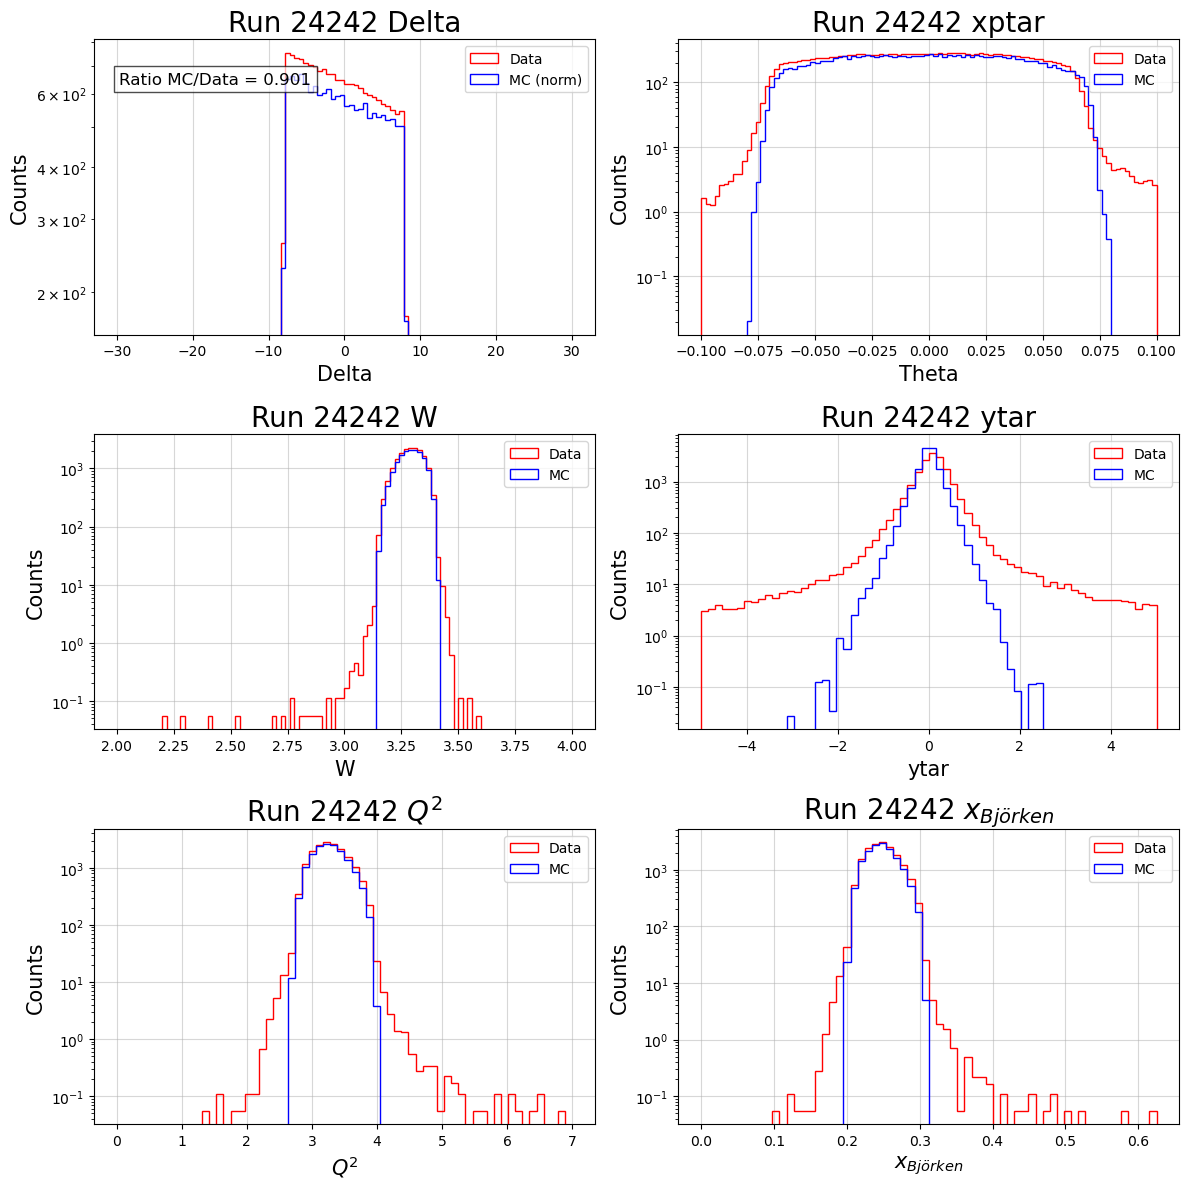

In [1]:
import uproot
import awkward as ak
from array import array
import sys,os
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.optimize import curve_fit
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter

# -----------------------------------------------------
# Settings
# -----------------------------------------------------

run_number = 24242
run_number_positron = 24549 # Positron background run number
normfac = 0.65544114803400300
# The following values are read from replay_hms_coin_production_{run_number} under Report_Output.  I've copied example values and variable callouts beside each quantity.
beam_charge = 18122.907 # BCM4C Beam Cut Charge: 18122.907 uC, directly printed from the report file
dead_time = 1
# dead_time = 0.922309 # HMS Computer Dead Time : 92.2309 % [ 107.7691 %  ]
tracking_eff = 0.9984 # SING FID TRACK EFFIC         :     0.9984 +-   0.0001
prescale_factor = 1 # Ps4_factor = 1
thickness = 0.171 # target thickness in g/cm^2
delta_hi = 10
delta_low = -10
A = 12.0107
N_A = 6.02214076e23 # Avogadro's number
q_e = 1.60217663e-19 # electron charge
p_spec = 1.531
nentries = 1000000
sim_charge = 1e-6
beam_charge_millicoulomb = beam_charge / 1000 #converting the beam charge to millicoulombs, for comparison with mc

# -----------------------------------------------------
# File paths
# -----------------------------------------------------

electron_file = f'/w/hallc-scshelf2102/c-rsidis/relder/ROOTfiles/hms_coin_replay_production_{run_number}_-1.root'
mc_file = f'/u/group/c-rsidis/relder/mc-single-arm/worksim/run_{run_number}_mc_single_arm.root'
positron_file = f"/w/hallc-scshelf2102/c-rsidis/relder/ROOTfiles/hms_coin_replay_production_{run_number_positron}_-1.root"


# -----------------------------------------------------
# Open files and access trees
# -----------------------------------------------------

def open_trees(file_tree_map):
    trees = {}
    for label, (file_path, tree_name) in file_tree_map.items():
        try:
            file = uproot.open(file_path)
            tree = file[tree_name]
            trees[label] = tree
            print(f"Successfully opened '{tree_name}' from: {file_path}")
        except Exception as e:
            print(f"Failed to open {tree_name} from {file_path}: {e}")
    return trees

# Tree mapping
file_tree_map = {
    "data": (electron_file, "T"),
    "mc": (mc_file, "h10"),
    "data_pos": (positron_file, "T")
}

trees = open_trees(file_tree_map)

electrons = trees["data"].arrays([
    "H.gtr.dp", "H.cal.etottracknorm", "H.gtr.ph", "H.gtr.th",
    "H.gtr.x", "H.gtr.y", "H.kin.Q2", "H.kin.x_bj", "H.kin.W", "H.cer.npeSum", "H.cal.etottracknorm"
], library="np")

#-----------------------------------
# Data
#-----------------------------------

#Variables
delta = electrons['H.gtr.dp']
cer = electrons['H.cer.npeSum']
cal = electrons['H.cal.etottracknorm']

#Data cuts
data_cut = ( (delta > -8) & (delta < 8) & (cer > 2) & (cal > 0.8) )

electrons_cut = {key: arr[data_cut] for key, arr in electrons.items()}

# Access the cut arrays individually:
delta_cut = electrons_cut['H.gtr.dp']
theta_cut = electrons_cut['H.gtr.th']
phi_cut = electrons_cut['H.gtr.ph']
xtar_cut = electrons_cut['H.gtr.x']
ytar_cut = electrons_cut['H.gtr.y']
Q2_cut = electrons_cut['H.kin.Q2']
xbj_cut = electrons_cut['H.kin.x_bj']
W_cut = electrons_cut['H.kin.W']

#-----------------------------------
# mc single arm
#-----------------------------------

electrons_mc= trees["mc"].arrays([
    "hsxfp", "hsyfp", "hsxpfp", "hsypfp", "hsdelta", "hsytar", "hsxptar", "hsyptar", "hsztar",
    "fry", "xsnum", "ysnum", "xsieve", "ysieve", "stop_id",
    "xb", "q2", "w", "eprime", "theta", "sigvert", "sigrad", "weight"
], library="np")

#Identifying variables of interest, mc
delta_mc = electrons_mc['hsdelta']

#MC cuts
mc_cut = ( (delta_mc > -8) & (delta_mc < 8) )

#Applying the mc cuts
electrons_mc_cut = {key: arr[mc_cut] for key, arr in electrons_mc.items()}

delta_mc_cut = electrons_mc_cut['hsdelta']
q2_mc_cut = electrons_mc_cut['q2']
xfp_mc_cut = electrons_mc_cut['hsxfp']
yfp_mc_cut = electrons_mc_cut['hsyfp']
xpfp_mc_cut = electrons_mc_cut['hsxpfp']
ypfp_mc_cut = electrons_mc_cut['hsypfp']
ytar_mc_cut = electrons_mc_cut['hsytar']
theta_mc_cut = electrons_mc_cut['hsxptar']
yptar_mc_cut = electrons_mc_cut['hsyptar']
ztar_mc_cut = electrons_mc_cut['hsztar']
fry_mc_cut = electrons_mc_cut['fry']
xsnum_mc_cut = electrons_mc_cut['xsnum']
ysnum_mc_cut = electrons_mc_cut['ysnum']
xsieve_mc_cut = electrons_mc_cut['xsieve']
ysieve_mc_cut = electrons_mc_cut['ysieve']
stop_id_mc_cut = electrons_mc_cut['stop_id']
xbj_mc_cut = electrons_mc_cut['xb']
w_mc_cut = electrons_mc_cut['w']
eprime_mc_cut = electrons_mc_cut['eprime']
sigvert_mc_cut = electrons_mc_cut['sigvert']
sigrad_mc_cut = electrons_mc_cut['sigrad']
weight_mc_cut = electrons_mc_cut['weight']

#-----------------------------------
# weights on data and mc
#-----------------------------------

weight_data = 1 / (beam_charge_millicoulomb * dead_time * tracking_eff)
weight_factor_data = np.full_like(delta_cut, fill_value=weight_data, dtype=float)
weight_factor_mc = weight_mc_cut * normfac * prescale_factor

#-----------------------------------
# Histogram settings
#-----------------------------------

#Delta histogram settings
bin_min_delta = -30
bin_max_delta = 30
bin_number_delta = 100
data_bins_delta = np.linspace(bin_min_delta, bin_max_delta, bin_number_delta + 1)
# Generate evenly spaced bins. +1 because to get bin_number bins, you need bin_number + 1 bin edges.

#Theta/xptar histogram settings
bin_min_theta = -.1
bin_max_theta = .1
bin_number_theta = 100
data_bins_theta = np.linspace(bin_min_theta, bin_max_theta, bin_number_theta + 1) 

#W histogram settings
bin_min_W = 2 
bin_max_W = 4
bin_number_W = 100
data_bins_W = np.linspace(bin_min_W, bin_max_W, bin_number_W + 1)

#ytar histogram settings
bin_min_ytar = -5
bin_max_ytar = 5
bin_number_ytar = 64
data_bins_ytar = np.linspace(bin_min_ytar, bin_max_ytar, bin_number_ytar + 1)

#Q2 histogram settings
bin_min_Q2 = 0
bin_max_Q2 = 7
bin_number_Q2 = 64
data_bins_Q2 = np.linspace(bin_min_Q2, bin_max_Q2, bin_number_Q2 + 1)

#x_Bj histogram settings
bin_min_xbj = 0
bin_max_xbj = .625
bin_number_xbj = 64
data_bins_xbj = np.linspace(bin_min_xbj, bin_max_xbj, bin_number_xbj + 1)

#-----------------------------------
# Ratios
#-----------------------------------
def integrate_hist(data_array, weights, bins):
    counts, bin_edges = np.histogram(data_array, bins=bins, weights=weights)
    bin_widths = np.diff(bin_edges)
    integral = np.sum(counts * bin_widths)
    return integral

#-----------------------------------
# Calculate integrals for data and MC for each variable
#-----------------------------------

integrals = {}

integrals['Delta_data'] = integrate_hist(delta_cut, weight_factor_data, data_bins_delta)
integrals['Delta_mc'] = integrate_hist(delta_mc_cut, weight_factor_mc, data_bins_delta)

integrals['Theta_data'] = integrate_hist(theta_cut, weight_factor_data, data_bins_theta)
integrals['Theta_mc'] = integrate_hist(theta_mc_cut, weight_factor_mc, data_bins_theta)

integrals['W_data'] = integrate_hist(W_cut, weight_factor_data, data_bins_W)
integrals['W_mc'] = integrate_hist(w_mc_cut, weight_factor_mc, data_bins_W)

integrals['ytar_data'] = integrate_hist(ytar_cut, weight_factor_data, data_bins_ytar)
integrals['ytar_mc'] = integrate_hist(ytar_mc_cut, weight_factor_mc, data_bins_ytar)

integrals['Q2_data'] = integrate_hist(Q2_cut, weight_factor_data, data_bins_Q2)
integrals['Q2_mc'] = integrate_hist(q2_mc_cut, weight_factor_mc, data_bins_Q2)

integrals['xbj_data'] = integrate_hist(xbj_cut, weight_factor_data, data_bins_xbj)
integrals['xbj_mc'] = integrate_hist(xbj_mc_cut, weight_factor_mc, data_bins_xbj)

# Calculate ratios MC/Data
ratios = {}
for var in ['Delta', 'Theta', 'W', 'ytar', 'Q2', 'xbj']:
    data_int = integrals[f'{var}_data']
    mc_int = integrals[f'{var}_mc']
    ratio = mc_int / data_int if data_int != 0 else np.nan
    ratios[var] = ratio
    print(f'Integral ratio MC/Data for {var}: {ratio:.4f}')

#-----------------------------------
# Plotting
#-----------------------------------

fig, axes = plt.subplots(3, 2, figsize=(12, 12))

#Subplot Delta
axes[0,0].hist(delta_cut, bins=data_bins_delta, weights=weight_factor_data, histtype='step', color='red', label='Data')
axes[0,0].hist(delta_mc_cut, bins=data_bins_delta, weights=weight_factor_mc, histtype='step', color='blue', label='MC (norm)')
axes[0,0].set_xlabel('Delta', fontsize=15)
axes[0,0].set_ylabel('Counts', fontsize=15)
axes[0,0].set_title(f'Run {run_number} Delta', fontsize=20)
axes[0,0].legend()
axes[0,0].grid(alpha=0.5)
axes[0,0].set_yscale('log')
axes[0,0].text(0.05, 0.85, f'Ratio MC/Data = {ratios["Delta"]:.3f}', transform=axes[0,0].transAxes,
               fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.7))


#Subplot Theta
axes[0,1].hist(theta_cut, bins=data_bins_theta, weights=weight_factor_data, histtype='step', color='red', label='Data')
axes[0,1].hist(theta_mc_cut, bins=data_bins_theta, weights=weight_factor_mc, histtype='step', color='blue', label='MC')
axes[0,1].set_xlabel('Theta', fontsize=15)
axes[0,1].set_ylabel('Counts', fontsize=15)
axes[0,1].set_title(f'Run {run_number} xptar', fontsize=20)
axes[0,1].legend()
axes[0,1].grid(alpha=0.5)
axes[0,1].set_yscale('log')

#Subplot W
axes[1,0].hist(W_cut, bins=data_bins_W, weights=weight_factor_data, histtype='step', color='red', label='Data')
axes[1,0].hist(w_mc_cut, bins=data_bins_W, weights=weight_factor_mc, histtype='step', color='blue', label='MC')
axes[1,0].set_xlabel('W', fontsize=15)
axes[1,0].set_ylabel('Counts', fontsize=15)
axes[1,0].set_title(f'Run {run_number} W', fontsize=20)
axes[1,0].legend()
axes[1,0].grid(alpha=0.5)
axes[1,0].set_yscale('log')

#Subplot ytar
axes[1,1].hist(ytar_cut, bins=data_bins_ytar, weights=weight_factor_data, histtype='step', color='red', label='Data')
axes[1,1].hist(ytar_mc_cut, bins=data_bins_ytar, weights=weight_factor_mc, histtype='step', color='blue', label='MC')
axes[1,1].set_xlabel('ytar', fontsize=15)
axes[1,1].set_ylabel('Counts', fontsize=15)
axes[1,1].set_title(f'Run {run_number} ytar', fontsize=20)
axes[1,1].legend()
axes[1,1].grid(alpha=0.5)
axes[1,1].set_yscale('log')

#Subplot Q2
axes[2,0].hist(Q2_cut, bins=data_bins_Q2, weights=weight_factor_data, histtype='step', color='red', label='Data')
axes[2,0].hist(q2_mc_cut, bins=data_bins_Q2, weights=weight_factor_mc, histtype='step', color='blue', label='MC')
axes[2,0].set_xlabel('$Q^{2}$', fontsize=15)
axes[2,0].set_ylabel('Counts', fontsize=15)
axes[2,0].set_title(f'Run {run_number} $Q^{2}$', fontsize=20)
axes[2,0].legend()
axes[2,0].grid(alpha=0.5)
axes[2,0].set_yscale('log')

#Subplot xbj
axes[2,1].hist(xbj_cut, bins=data_bins_xbj, weights=weight_factor_data, histtype='step', color='red', label='Data')
axes[2,1].hist(xbj_mc_cut, bins=data_bins_xbj, weights=weight_factor_mc, histtype='step', color='blue', label='MC')
axes[2,1].set_xlabel('$x_{Björken}$', fontsize=15)
axes[2,1].set_ylabel('Counts', fontsize=15)
axes[2,1].set_title(f'Run {run_number} $x_{{Björken}}$', fontsize=20)
axes[2,1].legend()
axes[2,1].grid(alpha=0.5)
axes[2,1].set_yscale('log')

#Adjusting the layout
plt.tight_layout()

#Saving the plots
plt.savefig('Plots.pdf')

#Displaying the plots
plt.show()